Tom Genlis - EPITA 2024 - SCIA - CV
# Recommender System based on Neural Networks
## Customer Order Prediction with TensorFlow

This notebook is focused on predicting customer orders using various pieces of information about the customer, the vendor, and the orders that have been made. It uses TensorFlow, to train a deep learning model for this task.

The notebook uses different data preprocessing techniques to format and clean the data, which is then used to train a neural network model. The neural network model consists of several densely connected layers and uses the Adam optimizer and binary cross-entropy as the loss function.

### Libraries
The script uses several Python libraries, including:

- ```pandas```: used for data manipulation and analysis.
- ```numpy```: used for numerical computations.
- ```tensorflow```: used to build and train the machine learning model.
- ```sklearn```: used for data preprocessing and splitting the dataset into training and validation sets.
- ```matplotlib```: used for data visualization.
tensorflow_addons: provides additional functionality to TensorFlow.
- ```sklearn.metrics```: used for computing the f1 score.

In [1]:
# Import necessary libraries for the task
import pandas as pd
from tensorflow.keras import layers, losses, optimizers
import tensorflow_addons as tfa
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import itertools

### Datasets
Several datasets are used in this script:

- ```test_customers.csv```: Contains information about the test customers.
- ```test_locations.csv```: Contains information about the test locations.
- ```train_customers.csv```: Contains information about the train customers.
- ```train_locations.csv```: Contains information about the train locations.
- ```vendors.csv```: Contains information about the vendors.
- ```orders.csv```: Contains information about the orders.

In [2]:
# Read the data from CSV files into pandas dataframes
df_test_customers = pd.read_csv('../data/test_customers.csv')
df_test_locations = pd.read_csv('../data/test_locations.csv')
df_train_customers = pd.read_csv('../data/train_customers.csv')
df_train_locations = pd.read_csv('../data/train_locations.csv')
df_vendors = pd.read_csv('../data/vendors.csv')
df_orders = pd.read_csv('../data/orders.csv')

C:\Users\Tom\AppData\Local\Temp\ipykernel_14500\2303872769.py:7: DtypeWarning: Columns (15,16,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_orders = pd.read_csv('../data/orders.csv')


### Data Preprocessing

The data is preprocessed through several steps to clean and format the data. This includes dropping unnecessary columns, filling missing values, transforming categorical variables into numerical variables, merging dataframes, and normalizing the data.

Many data are irrelevant, as described by the ```describe()``` function in pandas which gives us the following output:

In [3]:
print(len(df_train_customers.index))

df_train_customers.describe(include='all')

34674


,akeed_customer_id,gender,dob,status,verified,language,created_at,updated_at
count,34674,22520,3046.000000,34674.000000,34674.000000,21099,34674,34674
unique,34523,10,NaN,NaN,NaN,1,33650,29409
top,0FOCFVI,Male,NaN,NaN,NaN,EN,2019-10-14 12:20:33,2019-10-01 18:50:31
freq,17,17815,NaN,NaN,NaN,21099,7,15
mean,NaN,NaN,1991.210768,0.998991,0.956538,NaN,NaN,NaN
std,NaN,NaN,48.422045,0.031756,0.203898,NaN,NaN,NaN
min,NaN,NaN,1.000000,0.000000,0.000000,NaN,NaN,NaN
25%,NaN,NaN,1986.000000,1.000000,1.000000,NaN,NaN,NaN
50%,NaN,NaN,1993.000000,1.000000,1.000000,NaN,NaN,NaN
75%,NaN,NaN,1999.000000,1.000000,1.000000,NaN,NaN,NaN


```language```, ```dob``` or other sparse columns are real values for less than 10% of the rows, this is why we have to drop them.

Besides some data are float or int 64 types, which is too expensive compared to its real range of values, so we convert them to int8, int16 or bool to save memory.

We keep reiterating this process until we have a clean dataset that can be used to train the model.

We also need to merge the locations of customers and the customers dataframe.

### Training Strategy

The training data strategy will be crossing the customers, locations per customer and vendors to get every single possibility of orders. Then the target value will be 1 if the order exists in the order dataframe, otherwise 0.

In [4]:
# Functions to clean and format the data

def format_customers(df_customers, df_locations):
    """
    Function to format the customers data
    """
    # Drop unnecessary columns
    df_customers = df_customers.drop(["language", "dob", "created_at", "updated_at"], axis=1)

    # Clean and map gender data
    df_customers["gender"] = df_customers["gender"].str.strip()
    df_customers["gender"] = df_customers["gender"].str.upper()
    df_customers["gender"] = df_customers["gender"].map({'MALE': 0, 'FEMALE': 1})
    df_customers["gender"] = df_customers.gender.fillna(2).astype(int)

    # Select only verified and active customers
    df_customers = df_customers[(df_customers.verified == 1) & (df_customers.status == 1)].drop(["verified", "status"], axis=1)
    df_customers = df_customers.rename(columns={"akeed_customer_id": "customer_id"})

    # Merge with location data
    df_customers = pd.merge(df_customers, df_locations[["customer_id", "location_number", "latitude", "longitude"]], on="customer_id", how="outer")
    df_customers = df_customers.fillna(0)

    # Convert data types to save memory
    df_customers["gender"] = df_customers["gender"].astype(np.uint8)
    df_customers["location_number"] = df_customers["location_number"].astype(np.uint8)
    df_customers["latitude"] = df_customers["latitude"].astype(np.float16)
    df_customers["longitude"] = df_customers["longitude"].astype(np.float16)

    return df_customers

def format_items(df_orders):
    """
    Function to format the items data
    """
    # Drop unnecessary columns
    df_orders = df_orders[["customer_id", "vendor_id", "deliverydistance", "LOCATION_NUMBER"]]

    return df_orders

def format_vendors(df_vendors):
    """
    Function to format the vendors data
    """

    # Drop unnecessary columns
    to_remove = [
            "vendor_category_en",
            "authentication_id",
            "OpeningTime",
            "OpeningTime2",
            "open_close_flags",
            "vendor_tag_name",
            "created_at",
            "updated_at",
            "commission",
            "saturday_to_time1",
            "saturday_from_time2",
            "saturday_from_time1",
            "saturday_to_time2",
            "thursday_to_time1",
            "thursday_from_time1",
            "thursday_from_time2",
            "thursday_to_time2",
            "tuesday_to_time1",
            "tuesday_from_time2",
            "tuesday_from_time1",
            "tuesday_to_time2",
            "monday_to_time1",
            "monday_from_time1",
            "monday_from_time2",
            "monday_to_time2",
            "sunday_to_time1",
            "sunday_from_time1",
            "sunday_from_time2",
            "sunday_to_time2",
            "friday_to_time1",
            "friday_from_time1",
            "friday_from_time2",
            "friday_to_time2",
            "wednesday_to_time1",
            "wednesday_from_time1",
            "wednesday_from_time2",
            "wednesday_to_time2",
            "one_click_vendor",
            "country_id",
            "city_id",
            "display_orders",
            "device_type",
            "is_akeed_delivering",
            "language",
            "rank",
            "is_open",
            "verified"
    ]
    df_vendors = df_vendors.drop(to_remove, axis=1)

    # Parse primary_tags
    df_vendors["primary_tags"] = df_vendors["primary_tags"].fillna("{\"primary_tags\":\"0\"}").astype(str).map(lambda x: x.split("\"")[3]).astype(int)

    # Parsing and one hot encoding for vendor_tag
    df_vendors_tags = df_vendors.vendor_tag.str.split(",")
    df_vendors_tags = df_vendors_tags.apply(lambda d: d if isinstance(d, list) else [])

    mlb = MultiLabelBinarizer()
    one_hot_encoded_data = mlb.fit_transform(df_vendors_tags)
    one_hot_encoded_data = pd.DataFrame(one_hot_encoded_data, columns=mlb.classes_, dtype=bool)

    # Concat df_train_items and one_hot_encoded_data
    df_vendors = df_vendors.drop(["vendor_tag"], axis=1)
    df_vendors = df_vendors.reset_index(drop=True)
    one_hot_encoded_data = one_hot_encoded_data.reset_index(drop=True)
    df_vendors = pd.concat([df_vendors, one_hot_encoded_data], axis=1)

    # Convert data types to save memory
    df_vendors["latitude"] = df_vendors["latitude"].astype(np.float16)
    df_vendors["longitude"] = df_vendors["longitude"].astype(np.float16)
    df_vendors["vendor_category_id"] = df_vendors["vendor_category_id"].astype(np.uint8)
    df_vendors["delivery_charge"] = df_vendors["delivery_charge"].astype(bool)
    df_vendors["serving_distance"] = df_vendors["serving_distance"].astype(np.uint8)
    df_vendors["prepration_time"] = df_vendors["prepration_time"].astype(np.uint8)
    df_vendors["discount_percentage"] = df_vendors["discount_percentage"].astype(np.uint8)
    df_vendors["status"] = df_vendors["status"].astype(bool)
    df_vendors["vendor_rating"] = df_vendors["vendor_rating"].astype(np.float16)
    df_vendors["primary_tags"] = df_vendors["primary_tags"].astype(np.uint16)
    df_vendors["id"] = df_vendors["id"].astype(np.uint16)
    
    return df_vendors

def format_train_dataset(df_customers, df_orders, df_vendors, df_locations):
    df_customers = format_customers(df_customers, df_locations)
    df_orders = format_items(df_orders)
    df_vendors = format_vendors(df_vendors)

    # Remove users that are not in df_items
    df_customers = df_customers[df_customers['customer_id'].isin(df_orders['customer_id'])]

    # Cross product of customers and vendors
    # This gives us all the possible triples (customer_id, location_number, vendor_id)
    C = pd.merge(df_customers, df_vendors, how="cross")

    # Check if triple (customer_id, location_number, vendor_id) is in df_orders and put it in target
    triplets = set(df_orders[["customer_id", "LOCATION_NUMBER", "vendor_id"]].itertuples(index=False))
    C["target"] = C.apply(lambda x: 1 if (x["customer_id"], x["location_number"], x["id"]) in triplets else 0, axis=1)

    # Fill NaNs with 0s
    C = C.fillna(0)

    # balance the number of positive and negative samples according to y_train
    C = C.groupby('target').apply(lambda x: x.sample(C['target'].value_counts().min()).reset_index(drop=True))
    y_train = C["target"].reset_index(drop=True)
    C = C.drop(["customer_id", "id", "target"], axis=1)
    C = C.reset_index(drop=True)

    return C, y_train

In [5]:
# Load data
df_X_train, df_y_train = format_train_dataset(df_train_customers, df_orders, df_vendors, df_train_locations)

In [6]:
# Convert to numpy
np_X_train = df_X_train.to_numpy()
np_y_train = df_y_train.to_numpy()

Now that our data is clean, we need to convert it to tensors, which are multi-dimensional arrays with a uniform type. We can do this by converting the dataframes to numpy arrays and then to tensors, which are supported by TensorFlow.

In [7]:
def dataframe_to_dataset(np_X_train, np_y_train):
    """
    Convert numpy arrays to tensorflow datasets
    """

    # Split train and validation
    X_train, X_val, y_train, y_val = train_test_split(
        np_X_train, np_y_train, train_size=0.80, shuffle=True, random_state=42
    )
    print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

    size_train = X_train.shape[0]
    size_val = X_val.shape[0]
    input_shape_y = X_train.shape[-1]

    # Convert to tensors
    X_train = tf.keras.utils.normalize(tf.convert_to_tensor(X_train, dtype=tf.float32), axis=1)
    X_val = tf.keras.utils.normalize(tf.convert_to_tensor(X_val, dtype=tf.float32), axis=1)
    y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
    y_val = tf.convert_to_tensor(y_val, dtype=tf.float32)

    # Create tensorflow datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    del X_train, y_train
    valid_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    del X_val # , y_val

    batch_size = 2048

    # Batch the datasets
    train_dataset = train_dataset.batch(batch_size).prefetch(2)
    valid_dataset = valid_dataset.batch(batch_size).prefetch(2)
    
    return input_shape_y, y_val, train_dataset, valid_dataset

In [8]:
# Convert to tensorflow datasets
input_shape_y, y_val, train_dataset, valid_dataset = dataframe_to_dataset(np_X_train, np_y_train)

(128227, 81) (128227,) (32057, 81) (32057,)


### Machine Learning Model

The script uses a neural network model with several densely connected layers. The model uses the Adam optimizer and binary cross-entropy as the loss function. The model is trained with a batch size of 2048 for a maximum of 100 epochs.

In [9]:
# Create model
model = tf.keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(input_shape_y,)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer=optimizers.Adam(learning_rate=0.01),
                loss=losses.BinaryCrossentropy(),
                metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               10496     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 20,865
Trainable params: 20,865
Non-trainable params: 0
_________________________________________________________________


### Model Training
The model is trained using the processed data, with the output variable being whether or not the customer will place an order. During training, the learning rate is reduced if the validation loss does not improve after a certain number of epochs (patience), and the training is stopped if the validation loss does not improve after a certain number of epochs.

In [10]:
# Reduce learning rate on plateau
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001, verbose=1)

# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

epochs = 100

# Train model
history = model.fit(train_dataset, epochs=epochs, validation_data=valid_dataset, callbacks=[reduce_lr, early_stopping])

Epoch 1/100
63/63 [==============================] - 7s 34ms/step - loss: 0.6716 - recall: 0.5876 - precision: 0.5741 - val_loss: 0.6443 - val_recall: 0.5444 - val_precision: 0.6444 - lr: 0.0100
Epoch 2/100
63/63 [==============================] - 2s 29ms/step - loss: 0.6214 - recall: 0.6359 - precision: 0.6532 - val_loss: 0.6067 - val_recall: 0.7705 - val_precision: 0.6401 - lr: 0.0100
Epoch 3/100
63/63 [==============================] - 2s 30ms/step - loss: 0.5862 - recall: 0.7229 - precision: 0.6658 - val_loss: 0.5864 - val_recall: 0.5377 - val_precision: 0.7636 - lr: 0.0100
Epoch 4/100
63/63 [==============================] - 2s 39ms/step - loss: 0.5580 - recall: 0.7694 - precision: 0.6746 - val_loss: 0.5463 - val_recall: 0.8431 - val_precision: 0.6735 - lr: 0.0100
Epoch 5/100
63/63 [==============================] - 2s 38ms/step - loss: 0.5426 - recall: 0.7955 - precision: 0.6769 - val_loss: 0.5407 - val_recall: 0.6120 - val_precision: 0.7566 - lr: 0.0100
Epoch 6/100
63/63 [======

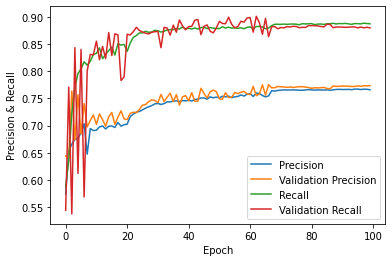

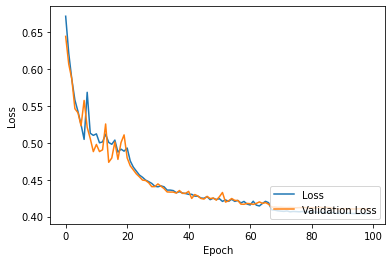

In [11]:
# Plot F1score
plt.plot(history.history['precision'], label='Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.plot(history.history['recall'], label='Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Precision & Recall')
plt.legend(loc='lower right')
plt.show()

# Plot Loss
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

### Model Evaluation
The model's performance is evaluated using precision, recall, and F1 score. The precision and recall for each epoch during training are visualized using matplotlib. The F1 score is calculated after making predictions on the validation set.

In [25]:
# Predict on validation set
y_pred = model.predict(valid_dataset)
y_pred = np.where(y_pred > 0.5, 1, 0)
y_pred = y_pred.reshape(-1)

# Print number of 1s and 0s
print("1 count", np.count_nonzero(y_pred == 1))
print("0 count", np.count_nonzero(y_pred == 0))

# Print F1 Score
print("F1 Score : ", f1_score(y_val.numpy().astype(int), y_pred))

16/16 [==============================] - 0s 11ms/step
1 count 18385
0 count 13672
F1 Score :  0.8229573673699747


In [26]:
def format_customers(df_customers, df_locations):
    df_customers = df_customers.drop(["language", "dob", "created_at", "updated_at"], axis=1)

    df_customers["gender"] = df_customers["gender"].str.strip()
    df_customers["gender"] = df_customers["gender"].str.upper()
    df_customers["gender"] = df_customers["gender"].map({'MALE': 0, 'FEMALE': 1})
    df_customers["gender"] = df_customers.gender.fillna(2).astype(int)

    df_customers = df_customers.drop(["verified", "status"], axis=1)
    df_customers = df_customers.rename(columns={"akeed_customer_id": "customer_id"})

    df_customers = pd.merge(df_customers, df_locations[["customer_id", "location_number", "latitude", "longitude"]], on="customer_id", how="outer")
    df_customers = df_customers.fillna(0)

    df_customers["gender"] = df_customers["gender"].astype(np.uint8)
    df_customers["location_number"] = df_customers["location_number"].astype(np.uint8)
    df_customers["latitude"] = df_customers["latitude"].astype(np.float16)
    df_customers["longitude"] = df_customers["longitude"].astype(np.float16)

    return df_customers

def format_items(df_orders):
    df_orders = df_orders[["akeed_order_id", "customer_id", "vendor_id", "deliverydistance"]]

    df_orders = df_orders.drop(["akeed_order_id"], axis=1)
    return df_orders

def format_vendors(df_vendors):
    to_remove = [
            "vendor_category_en",
            "authentication_id",
            "OpeningTime",
            "OpeningTime2",
            "open_close_flags",
            "vendor_tag_name",
            "created_at",
            "updated_at",
            "commission",
            "saturday_to_time1",
            "saturday_from_time2",
            "saturday_from_time1",
            "saturday_to_time2",
            "thursday_to_time1",
            "thursday_from_time1",
            "thursday_from_time2",
            "thursday_to_time2",
            "tuesday_to_time1",
            "tuesday_from_time2",
            "tuesday_from_time1",
            "tuesday_to_time2",
            "monday_to_time1",
            "monday_from_time1",
            "monday_from_time2",
            "monday_to_time2",
            "sunday_to_time1",
            "sunday_from_time1",
            "sunday_from_time2",
            "sunday_to_time2",
            "friday_to_time1",
            "friday_from_time1",
            "friday_from_time2",
            "friday_to_time2",
            "wednesday_to_time1",
            "wednesday_from_time1",
            "wednesday_from_time2",
            "wednesday_to_time2",
            "one_click_vendor",
            "country_id",
            "city_id",
            "display_orders",
            "device_type",
            "is_akeed_delivering",
            "language",
            "rank",
            "is_open"
    ]

    df_vendors = df_vendors.drop(to_remove, axis=1)
    # remove all unverified accounts
    # df_vendors = df_vendors[df_vendors["verified"] == 1]
    df_vendors = df_vendors.drop("verified", axis=1)
    df_vendors["primary_tags"] = df_vendors["primary_tags"].fillna("{\"primary_tags\":\"0\"}").astype(str).map(lambda x: x.split("\"")[3]).astype(int)

    # one hot encoding for vendor_tag
    df_vendors_tags = df_vendors.vendor_tag.str.split(",")
    df_vendors_tags = df_vendors_tags.apply(lambda d: d if isinstance(d, list) else [])

    mlb = MultiLabelBinarizer()
    one_hot_encoded_data = mlb.fit_transform(df_vendors_tags)
    one_hot_encoded_data = pd.DataFrame(one_hot_encoded_data, columns=mlb.classes_, dtype=bool)

    # merge df_train_items and one_hot_encoded_data
    df_vendors = df_vendors.drop(["vendor_tag"], axis=1)
    df_vendors = df_vendors.reset_index(drop=True)
    one_hot_encoded_data = one_hot_encoded_data.reset_index(drop=True)
    df_vendors = pd.concat([df_vendors, one_hot_encoded_data], axis=1)

    df_vendors["latitude"] = df_vendors["latitude"].astype(np.float16)
    df_vendors["longitude"] = df_vendors["longitude"].astype(np.float16)
    df_vendors["vendor_category_id"] = df_vendors["vendor_category_id"].astype(np.uint8)
    df_vendors["delivery_charge"] = df_vendors["delivery_charge"].astype(bool)
    df_vendors["serving_distance"] = df_vendors["serving_distance"].astype(np.uint8)
    df_vendors["prepration_time"] = df_vendors["prepration_time"].astype(np.uint8)
    df_vendors["discount_percentage"] = df_vendors["discount_percentage"].astype(np.uint8)
    df_vendors["status"] = df_vendors["status"].astype(bool)
    df_vendors["vendor_rating"] = df_vendors["vendor_rating"].astype(np.float16)
    df_vendors["primary_tags"] = df_vendors["primary_tags"].astype(np.uint16)
    df_vendors["id"] = df_vendors["id"].astype(np.uint16)
    
    return df_vendors

def format_test_dataset(df_customers, df_orders, df_vendors, df_locations):
    df_customers = format_customers(df_customers, df_locations)
    df_orders = format_items(df_orders)
    df_vendors = format_vendors(df_vendors)

    print(df_customers.shape, df_orders.shape, df_vendors.shape)

    # get the cross merge product of users, items and rests
    
    C = pd.merge(df_customers, df_vendors, how="cross")
    sub = C[["customer_id", "location_number", "id"]]
    C = C.drop(["customer_id", "id"], axis=1)

    return C, sub

In [27]:
df_X_test, df_submission = format_test_dataset(df_test_customers, df_orders, df_vendors, df_test_locations)

(16736, 5) (135303, 3) (100, 78)


In [28]:
X_test = tf.keras.utils.normalize(tf.convert_to_tensor(df_X_test.to_numpy(), dtype=tf.float32), axis=1)

In [30]:
# Predict the test set
y_pred = model.predict(X_test)
# Convert the prediction to binary
y_pred = np.where(y_pred > 0.5, 1, 0)
# Reshape the prediction to a 1D array
y_pred = y_pred.reshape(-1)

52300/52300 [==============================] - 183s 3ms/step


### Prediction

Finally, the trained model is used to predict whether a customer will place an order. The predictions are saved to a CSV file.

In [ ]:
# Create the submission file
df_submission["CID X LOC_NUM X VENDOR"] = df_submission["customer_id"].astype(str) + " X " + df_submission["location_number"].astype(str) + " X " + df_submission["id"].astype(str)
df_submission["target"] = y_pred
df_submission = df_submission.drop(["customer_id", "location_number", "id"], axis=1)
df_submission.to_csv("submission.csv", index=False)

Thank you for reading this notebook, I hope you enjoyed it ! 😄